<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

import nltk
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     D:\Programs\anaconda3\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\Programs\anaconda3\lib\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Подгрузим необходимые файлы для английской библиотеки лемматизатора:

In [3]:
nltk.download('punkt')
nltk.download('wordnet')

stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     D:\Programs\anaconda3\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Programs\anaconda3\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Подгрузим данные:

In [4]:
try:
    df = pd.read_csv('D:/DS/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Лишние символы в тексте очистим регулярными выражениями.

Это инструмент для поиска слова или числа по шаблону (pattern). Он определяет, из каких частей состоит строка и какие в них символы. Например, нужно найти все даты в таком формате записи: 28.06.2023. Их шаблон — это два числа, точка, два числа, точка, четыре числа.

Шаблон для email-адреса такой: строка на латинице, символ @, строка на латинице, точка, строка на латинице.

Для работы с регулярными выражениями в Python есть встроенный модуль `re` (сокр. от regular expressions).
Создадим функцию, которая очистит текст для будущей лемматизации:

In [5]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text.lower()) # преобразовываем и переводим в нижний регистр
    retext = text.split() 
    text = " ".join(retext)
    return text

Прежде чем извлечь признаки из текста, упростим его.

Рассмотрим этапы предобработки текста:

1. Токенизация (англ. tokenization) — разбиение текста на токены: отдельные фразы, слова, символы.
2. Лемматизация (англ. lemmatization) — приведение слова к начальной форме (лемме).

Создадим функцию для токенизации и лемматизации текста:

In [6]:
def lemmetize(words):
    lemmatizer = WordNetLemmatizer() 
    text = [] # создаём список для заполнения
    tokens = word_tokenize(words) # токенизируем текст
    for token in tokens: # лемматизируем каждый токен
        lemmetized_word = lemmatizer.lemmatize(token) 
        text.append(lemmetized_word)
    sentence = " ".join(text) # объединяем в текст обратно
    return sentence

Воспользуемся полученными функциями и посмотрим результат:

In [7]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    lemm_text = []
    for token, tag in pos_tags:
        if tag.startswith('NN'):
            pos = wordnet.NOUN
        elif tag.startswith('VB'):
            pos = wordnet.VERB
        elif tag.startswith('JJ'):
            pos = wordnet.ADJ
        elif tag.startswith('RB'):
            pos = wordnet.ADV
        else:
            pos = wordnet.NOUN
        lemm_word = lemmatizer.lemmatize(token, pos=pos)
        lemm_text.append(lemm_word)
    return ' '.join(lemm_text)

df['lemm_text'] = df['text'].apply(clear_text)
df['lemm_text'] = df['lemm_text'].apply(lemmatize)

df['lemm_text']

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it look like it be actually you who put on...
159291    and i really don t think you understand i come...
Name: lemm_text, Length: 159292, dtype: object

Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе (англ. corpus). Это набор текстов, в котором эмоции и ключевые слова уже размечены.

Разделим датасет на тестовую и тренировочную выборку, размер тестовой выборки - 20% от общих данных:

In [8]:
train_features, test_features, train_target, test_target = train_test_split(
    df.drop('toxic', axis=1),
    df['toxic'],
    test_size=0.2,
    random_state=12345,
    stratify=df['toxic'] # стратифицируем текст, чтобы выборки были более сбалансированы
)

# вытаскиваем корпусы
corpus_train = train_features['lemm_text']
corpus_test = test_features['lemm_text']
corpus_train

4627      i don t mean to intrude but i have notice the ...
23542     god or whoever whatever i now decree you the c...
128384    can we keep this neat and sequential we have a...
31111     here s what you say may rama blocked expires j...
41207     sir giggsy have often say that he like to keep...
                                ...                        
54715     indeed bigdunc that page rightly say that para...
75564     i m not try to make a point or anything except...
71196     forgive my cruddy formattingi m still relative...
55751     talk grasshopper scout i move your comment fro...
11543                                  oppose wp commonname
Name: lemm_text, Length: 127433, dtype: object

Мешок слов учитывает частоту употребления слов. Оценка важности слова определяется величиной `TF-IDF` (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). 

То есть `TF` отвечает за количество упоминаний слова в отдельном тексте, а `IDF` отражает частоту его употребления во всём корпусе.

Воспользуемся `TfidfVectorizer` и, чтобы почистить мешок слов, добавим в него стоп-слова:

In [9]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # подгружаем счетчик и задаём стоп-слова
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # обучаем и трансформируем
tf_idf_test = count_tf_idf.transform(corpus_test) # трансформируем тестовую без обучения

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (127433, 136976)
Размер матрицы: (31859, 136976)


Обработка данных выполнена, `TF-IDF` подсчитано, можно приступить к обучению модели:

## Обучение

Воспользуемся несколькими библиотеками и моделями машинного обучения:

1. Линейная регрессия
2. Дерево решений
3. Случайный лес 
4. Градиентный бустинг

Такими библиотеками, как:

* `sklearn`
* `XGBoost`
* `LightGBM`

Для подбора параметров деревянных моделей будем использовать `RandomizedSearchSV`, чтобы ускорить вычисления.

Создадим функцию, которая обучит и вернет модель, а также заполнит таблицу для анализа метрик:

In [10]:
# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=4, 
        verbose=2
    )
    
    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(tf_idf_train, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    # высчитаем метрики
    f1 = model_random.best_score_
    f1_on_train = f1_score(train_target, model_random.predict(tf_idf_train))
    
    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)

    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

**Логистическая регрессия**

In [11]:
# зададим рандомные параметры

ran_lr = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
}

logr = LogisticRegression(max_iter=1000)

lr_random = train_model(logr, ran_lr) # обучим и сохраним значения

D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 8 candidates, totalling 32 fits


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solve

RandomizedSearchCV подбирал параметры 368.55 секунд
Лучшие параметры: {'penalty': 'l2', 'class_weight': 'balanced'}
F1 обученной модели: 0.7424140918642892
F1 на тренировочной выборке: 0.8239697893202595


**Дерево решений**

In [12]:
# зададим рандомные параметры

ran_grid_tree = {
    "max_depth": list(range(45, 56))
}

dtr = DecisionTreeClassifier()

dtr_random = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

Fitting 4 folds for each of 10 candidates, totalling 40 fits
RandomizedSearchCV подбирал параметры 1201.44 секунд
Лучшие параметры: {'max_depth': 54}
F1 обученной модели: 0.7023682903483558
F1 на тренировочной выборке: 0.8258868128892499


**Случайный лес**

In [13]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': [300, 310],
    'n_estimators': [12, 14],
}

rfc = RandomForestClassifier(n_jobs=-1)

rfc_random = train_model(rfc, ran_grid_forest) # обучим и сохраним значения

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 982.14 секунд
Лучшие параметры: {'n_estimators': 12, 'max_depth': 310}
F1 обученной модели: 0.6092975042023525
F1 на тренировочной выборке: 0.9116868937135179


**LightGBM**

In [14]:
rand_lgbm_param = {
    'max_depth': [15, 25],
    'learning_rate': [0.1, 0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 389.96 секунд
Лучшие параметры: {'max_depth': 25, 'learning_rate': 0.3}
F1 обученной модели: 0.7636680344192088
F1 на тренировочной выборке: 0.8536252875521855


**XGBoost**

In [15]:
rand_xgb_param = {
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.5, 1.0]
}

xb = xgb.XGBClassifier(booster='gbtree', 
                      use_rmm=True,
                      n_jobs=-1)

xb_random = train_model(xb, rand_xgb_param)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 6425.15 секунд
Лучшие параметры: {'max_depth': 9, 'learning_rate': 0.5}
F1 обученной модели: 0.7520493941124535
F1 на тренировочной выборке: 0.8608725523874957


**Анализ полученных метрик и выбор модели:**

,model,F1_model,F1_on_train,names
0,LogisticRegression(max_iter=1000),0.742414,0.823970,LogisticRegression
1,DecisionTreeClassifier(),0.702368,0.825887,DecisionTree
2,RandomForestClassifier(n_jobs=-1),0.609298,0.911687,RandomForest
3,LGBMClassifier(),0.763668,0.853625,LightGBM
4,"XGBClassifier(base_score=None, booster='gbtree...",0.752049,0.860873,XGBoost


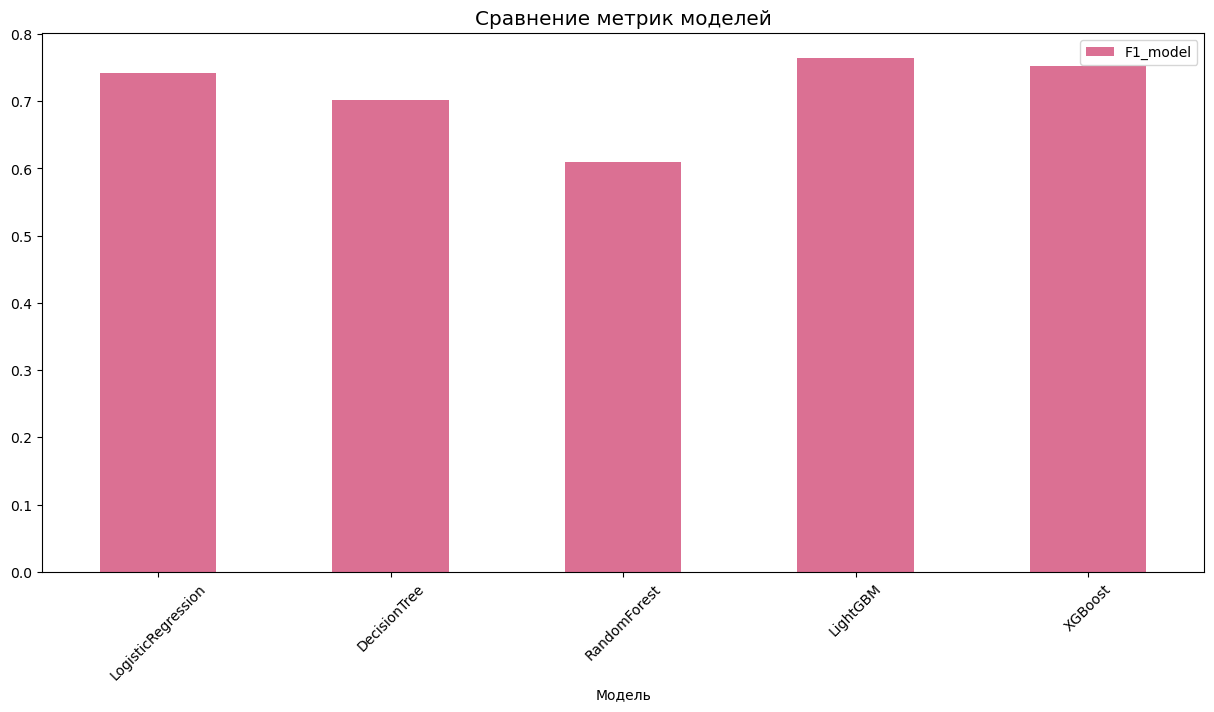

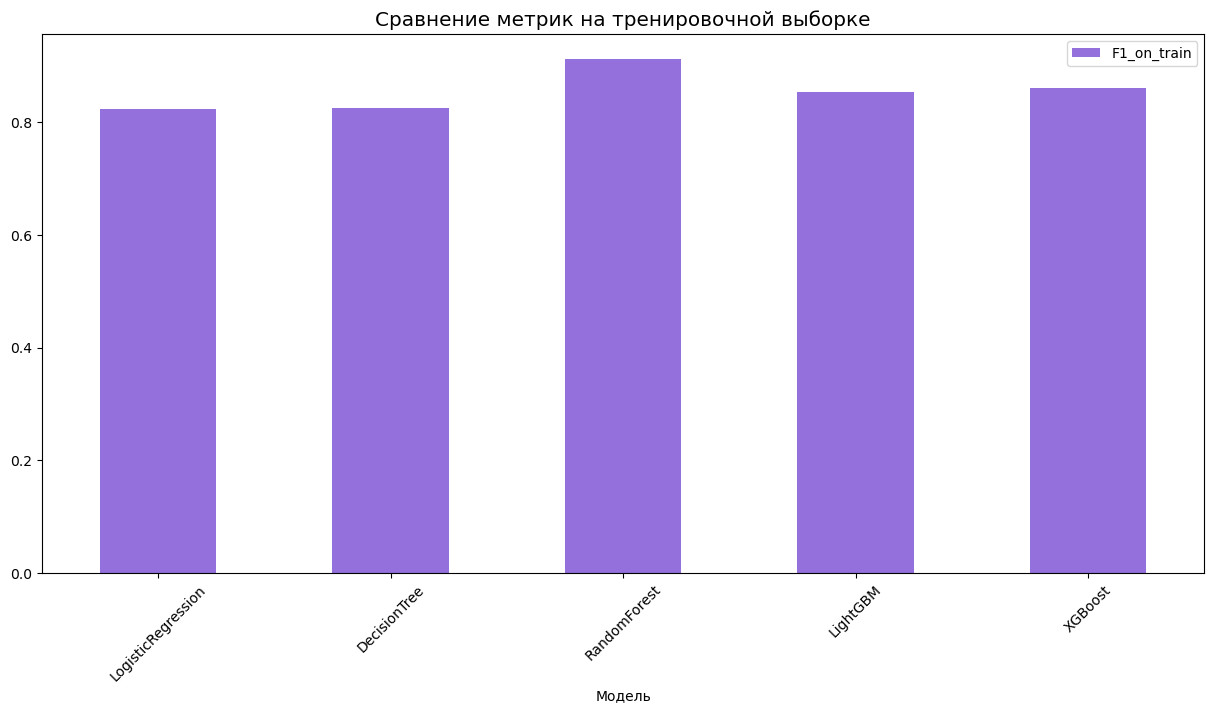

In [16]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(15,7), color='palevioletred')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', x='names', rot=45, figsize=(15,7), color='mediumpurple')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

**Общий вывод:**

Исходя из полученных метрик качества моделей, лучшая модель на `RandomizedSearchCV` - `LightGBM` c параметрами `max_depth`: 25, `learning_rate`: 0.3. На тренировочной выборке, лучшую метрику показывает модель Случайного леса, но и худшую на подборе параметров, то есть модель переобучена и не показывает нужных метрик.

Для финальных результатов и проверки качества на тестовой выборке воспользуемся моделью `LightGBM`, которая уже обучена.

## Выводы

Подсчитаем метрики на тестовой выборке:

In [18]:
predicted = gbm_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_target, predicted))

F1 лучшей модели на тестовой выборке: 0.7723183391003461


**Вывод:**

Необходимые метрики достигнуты, модель `LightGBM`, обученная через `RandomizedSearchCV`, предсказывает с необходимой метрикой: F1 > 0.75. 